In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN, GRU, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os


In [30]:
def load_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    input_texts = []
    target_texts = []
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            target, input = parts[0], parts[1]
            input_texts.append(input)
            target_texts.append('\t' + target + '\n')  # Add start/end tokens
    return input_texts, target_texts

train_inputs, train_targets = load_data("/content/hi.translit.sampled.train.tsv")
dev_inputs, dev_targets = load_data("/content/hi.translit.sampled.dev.tsv")
test_inputs, test_targets = load_data("/content/hi.translit.sampled.test.tsv")

input_characters = sorted(set(''.join(train_inputs + dev_inputs + test_inputs)))
target_characters = sorted(set(''.join(train_targets + dev_targets + test_targets)))

input_token_index = {char: i + 1 for i, char in enumerate(input_characters)}  # 0 for padding
target_token_index = {char: i + 1 for i, char in enumerate(target_characters)}
reverse_target_index = {i: char for char, i in target_token_index.items()}

num_encoder_tokens = len(input_token_index) + 1
num_decoder_tokens = len(target_token_index) + 1


In [ ]:
def encode_sequences(inputs, targets, input_index, target_index, max_encoder_len, max_decoder_len):
    encoder_input = [[input_index.get(c, 0) for c in seq] for seq in inputs]
    decoder_input = [[target_index.get(c, 0) for c in seq[:-1]] for seq in targets]
    decoder_output = [[target_index.get(c, 0) for c in seq[1:]] for seq in targets]

    encoder_input = pad_sequences(encoder_input, maxlen=max_encoder_len, padding='post')
    decoder_input = pad_sequences(decoder_input, maxlen=max_decoder_len-1, padding='post')
    decoder_output = pad_sequences(decoder_output, maxlen=max_decoder_len-1, padding='post')

    return encoder_input, decoder_input, tf.keras.utils.to_categorical(decoder_output, num_classes=num_decoder_tokens)

max_encoder_seq_length = max(len(seq) for seq in train_inputs)
max_decoder_seq_length = max(len(seq) for seq in train_targets)

train_enc, train_dec_in, train_dec_out = encode_sequences(train_inputs, train_targets, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)
dev_enc, dev_dec_in, dev_dec_out = encode_sequences(dev_inputs, dev_targets, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)
test_enc, test_dec_in, test_dec_out = encode_sequences(test_inputs, test_targets, input_token_index, target_token_index, max_encoder_seq_length, max_decoder_seq_length)


In [ ]:
num_samples_to_view = 5

reverse_input_index = {i: char for char, i in input_token_index.items()}
reverse_target_index = {i: char for char, i in target_token_index.items()}

print("🔍 Sample of Preprocessed Data:")
for i in range(num_samples_to_view):
    encoded_input = train_enc[i]
    encoded_target = np.argmax(train_dec_out[i], axis=-1)

    decoded_input = ''.join([reverse_input_index.get(idx, '') for idx in encoded_input if idx != 0])
    decoded_target = ''.join([reverse_target_index.get(idx, '') for idx in encoded_target if idx != 0])

    print(f"Latin Input (Encoded): {encoded_input}")
    print(f"Latin Input (Decoded): {decoded_input}")
    print(f"Devanagari Target (Encoded): {encoded_target}")
    print(f"Devanagari Target (Decoded):\t{decoded_target}")
    print('-' * 50)

🔍 Sample of Preprocessed Data:
Latin Input (Encoded): [ 1 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Latin Input (Decoded): an
Devanagari Target (Encoded): [6 4 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Devanagari Target (Decoded):	अं

--------------------------------------------------
Latin Input (Encoded): [ 1 14 11  7  1 14  9 20  0  0  0  0  0  0  0  0  0  0  0  0]
Latin Input (Decoded): ankganit
Devanagari Target (Encoded): [ 6  4 18 20 32 53 33  2  0  0  0  0  0  0  0  0  0  0  0  0]
Devanagari Target (Decoded):	अंकगणित

--------------------------------------------------
Latin Input (Encoded): [21 14  3 12  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Latin Input (Decoded): uncle
Devanagari Target (Encoded): [ 6  4 18 45  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Devanagari Target (Decoded):	अंकल

--------------------------------------------------
Latin Input (Encoded): [ 1 14 11 21 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Latin Input (Decoded): ankur
D

In [ ]:
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

def get_rnn_cell(cell_type, units, return_sequences=True, return_state=True):
    if cell_type == 'LSTM':
        return LSTM(units, return_sequences=return_sequences, return_state=return_state)
    elif cell_type == 'GRU':
        return GRU(units, return_sequences=return_sequences, return_state=return_state)
    elif cell_type == 'RNN':
        return SimpleRNN(units, return_sequences=return_sequences, return_state=return_state)
    else:
        raise ValueError(f"Unsupported cell type: {cell_type}")


In [ ]:
def build_seq2seq_model(cell_type="LSTM", embedding_dim=128, hidden_units=256):
    RNNCell = {"LSTM": LSTM, "GRU": GRU, "RNN": SimpleRNN}[cell_type]

    encoder_inputs = Input(shape=(None,))
    encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=embedding_dim)(encoder_inputs)
    encoder_outputs, *encoder_states = RNNCell(hidden_units, return_state=True)(encoder_embedding)

    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=embedding_dim)(decoder_inputs)
    decoder_rnn = RNNCell(hidden_units, return_sequences=True, return_state=True)
    decoder_outputs, *decoder_states = decoder_rnn(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model, encoder_states, decoder_rnn, decoder_dense


In [ ]:
model, encoder_states, decoder_rnn, decoder_dense = build_seq2seq_model(cell_type="LSTM")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    [train_enc, train_dec_in], train_dec_out,
    validation_data=([dev_enc, dev_dec_in], dev_dec_out),
    batch_size=64,
    epochs=30
)


Epoch 1/30
691/691 ━━━━━━━━━━━━━━━━━━━━ 155s 218ms/step - accuracy: 0.7062 - loss: 1.2245 - val_accuracy: 0.7633 - val_loss: 0.8461
Epoch 2/30
691/691 ━━━━━━━━━━━━━━━━━━━━ 146s 211ms/step - accuracy: 0.7719 - loss: 0.8024 - val_accuracy: 0.8333 - val_loss: 0.5682
Epoch 3/30
691/691 ━━━━━━━━━━━━━━━━━━━━ 146s 211ms/step - accuracy: 0.8469 - loss: 0.5141 - val_accuracy: 0.8932 - val_loss: 0.3509
Epoch 4/30
691/691 ━━━━━━━━━━━━━━━━━━━━ 146s 212ms/step - accuracy: 0.9043 - loss: 0.3107 - val_accuracy: 0.9210 - val_loss: 0.2540
Epoch 5/30
691/691 ━━━━━━━━━━━━━━━━━━━━ 202s 212ms/step - accuracy: 0.9316 - loss: 0.2214 - val_accuracy: 0.9321 - val_loss: 0.2175
Epoch 6/30
691/691 ━━━━━━━━━━━━━━━━━━━━ 201s 212ms/step - accuracy: 0.9448 - loss: 0.1778 - val_accuracy: 0.9361 - val_loss: 0.2011
Epoch 7/30
691/691 ━━━━━━━━━━━━━━━━━━━━ 202s 211ms/step - accuracy: 0.9537 - loss: 0.1489 - val_accuracy: 0.9409 - val_loss: 0.1868
Epoch 8/30
691/691 ━━━━━━━━━━━━━━━━━━━━ 202s 211ms/step - accuracy: 0.9605 -

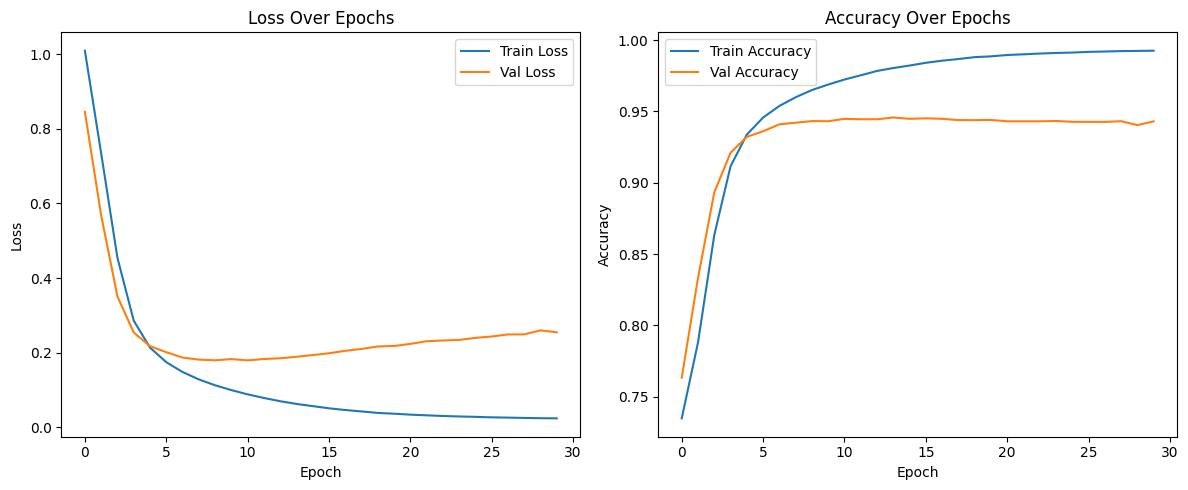

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [ ]:
train_loss, train_acc = model.evaluate([train_enc, train_dec_in], train_dec_out, verbose=0)
test_loss, test_acc = model.evaluate([test_enc, test_dec_in], test_dec_out, verbose=0)
print(f" Train Accuracy: {train_acc * 100:.2f}%")
print(f" Test Accuracy: {test_acc * 100:.2f}%")


 Train Accuracy: 99.41%
 Test Accuracy: 94.40%


In [ ]:
# Encoder model
encoder_model = Model(model.input[0], encoder_states)

# Decoder model
decoder_input_h = Input(shape=(256,))
decoder_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_input_h, decoder_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_emb_inf = model.layers[3](decoder_inputs_single)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_rnn(decoder_emb_inf, initial_state=decoder_states_inputs)
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs_inf, state_h_inf, state_c_inf]
)


In [ ]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_token_index['\t']
    decoded_sentence = ''
    while True:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_index.get(sampled_token_index, '')
        if sampled_char == '\n' or sampled_char == '':
            break
        decoded_sentence += sampled_char
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence

print("\n🔍 Sample Predictions:")
correct = 0
for i in range(20):
    input_text = test_inputs[i]
    input_seq = pad_sequences([[input_token_index.get(c, 0) for c in input_text]], maxlen=max_encoder_seq_length, padding='post')
    decoded = decode_sequence(input_seq)
    actual = test_targets[i][1:-1]
    print(f"Input: {input_text} => Predicted: {decoded} | Actual: {actual}")
    if decoded == actual:
        correct += 1

print(f"\n🎯 Accuracy on 20 samples: {correct / 20:.2f}")



🔍 Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Input: ank => Predicted: आंक | Actual: अंक
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Input: anka => Predicted: आंका | Actual: अंक
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Input: ankit => Predicted: अंकित | Actual: अंकित
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/

In [31]:
from nltk.translate.bleu_score import sentence_bleu

bleu_scores = []
for i in range(20):
    input_text = test_inputs[i]
    input_seq = pad_sequences([[input_token_index.get(c, 0) for c in input_text]], maxlen=max_encoder_seq_length, padding='post')
    decoded = decode_sequence(input_seq)
    actual = list(test_targets[i][1:-1])  # Actual Devanagari chars without start/end

    bleu = sentence_bleu([actual], list(decoded))
    bleu_scores.append(bleu)
    print(f"BLEU Score: {bleu:.2f} | Input: {input_text} => Predicted: {decoded} | Actual: {''.join(actual)}")

print(f"\n💯 Average BLEU Score on 20 samples: {sum(bleu_scores) / len(bleu_scores):.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
BLEU Score: 0.00 | Input: ank => Predicted: आंक | Actual: अंक
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
BLEU Score: 0.00 | Input: anka => Predicted: आंका | Actual: अंक
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
BLEU Score: 1.00 | Input: ankit => Predicted: अंकित | Actual: अंकित
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
BLEU Score: 0.00 | Input: anakon => Predicted: अनकों | Actual: अंकों
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


🔁 Training model with SimpleRNN
Epoch 1/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.1023 - loss: 2.8039
Epoch 2/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.1726 - loss: 1.8678
Epoch 3/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.2055 - loss: 1.5027
Epoch 4/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.2312 - loss: 1.2825
Epoch 5/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.2366 - loss: 1.1579
Epoch 6/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.2425 - loss: 1.0770
Epoch 7/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.2492 - loss: 1.0167
Epoch 8/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.2533 - loss: 0.9659
Epoch 9/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.2574 - loss: 0.9333
Epoch 10/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.2608 - loss: 0.8923
✅ Test Accuracy: 24.81%

🔁 Training model with LSTM
Epoch 1/10
759/759 ━━━━━━━━━━━━━━━

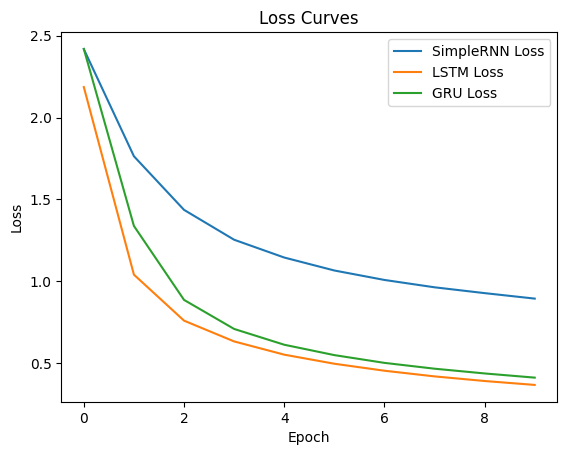


🏆 Best model type: LSTM
Epoch 1/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 84s 103ms/step - accuracy: 0.1032 - loss: 2.8223
Epoch 2/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - accuracy: 0.2343 - loss: 1.1875
Epoch 3/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - accuracy: 0.2742 - loss: 0.7868
Epoch 4/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 83s 103ms/step - accuracy: 0.2901 - loss: 0.6403
Epoch 5/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 84s 106ms/step - accuracy: 0.2991 - loss: 0.5528
Epoch 6/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 78s 103ms/step - accuracy: 0.3056 - loss: 0.4917
Epoch 7/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 83s 104ms/step - accuracy: 0.3113 - loss: 0.4461
Epoch 8/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 78s 102ms/step - accuracy: 0.3148 - loss: 0.4111
Epoch 9/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 78s 103ms/step - accuracy: 0.3184 - loss: 0.3827
Epoch 10/10
759/759 ━━━━━━━━━━━━━━━━━━━━ 79s 104ms/step - accuracy: 0.3208 - loss: 0.3606
✅ Test Accuracy: 29.12%
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
Input: ank → Predi

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Embedding, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ---------------------------
# Data Loading and Preprocessing
# ---------------------------

def load_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.read().strip().split('\n')
    source_texts, target_texts = [], []
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) < 2:
            continue
        tgt, src = parts[0], parts[1]
        source_texts.append(src)
        target_texts.append('\t' + tgt + '\n')  # Start and end tokens
    return source_texts, target_texts

def tokenize(texts):
    vocab = sorted(set(''.join(texts)))
    char2idx = {c: i+1 for i, c in enumerate(vocab)}
    idx2char = {i+1: c for i, c in enumerate(vocab)}
    return char2idx, idx2char, len(vocab) + 1

def preprocess_data(source_texts, target_texts):
    src_idx, src_rev, src_vocab_size = tokenize(source_texts)
    tgt_idx, tgt_rev, tgt_vocab_size = tokenize(target_texts)

    max_len_src = max(len(s) for s in source_texts)
    max_len_tgt = max(len(t) for t in target_texts)

    encoder_input = [[src_idx.get(c, 0) for c in s] for s in source_texts]
    decoder_input = [[tgt_idx.get(c, 0) for c in t[:-1]] for t in target_texts]
    decoder_target = [[tgt_idx.get(c, 0) for c in t[1:]] for t in target_texts]

    encoder_input = pad_sequences(encoder_input, maxlen=max_len_src, padding='post')
    decoder_input = pad_sequences(decoder_input, maxlen=max_len_tgt - 1, padding='post')
    decoder_target = pad_sequences(decoder_target, maxlen=max_len_tgt - 1, padding='post')

    return encoder_input, decoder_input, decoder_target, src_idx, tgt_idx, max_len_src, max_len_tgt - 1, src_vocab_size, tgt_vocab_size

# Apply train-time padding lengths to test data
def preprocess_data_fixed(source_texts, target_texts, src_idx, tgt_idx, max_len_src, max_len_tgt):
    encoder_input = [[src_idx.get(c, 0) for c in s] for s in source_texts]
    decoder_input = [[tgt_idx.get(c, 0) for c in t[:-1]] for t in target_texts]
    decoder_target = [[tgt_idx.get(c, 0) for c in t[1:]] for t in target_texts]

    encoder_input = pad_sequences(encoder_input, maxlen=max_len_src, padding='post')
    decoder_input = pad_sequences(decoder_input, maxlen=max_len_tgt, padding='post')
    decoder_target = pad_sequences(decoder_target, maxlen=max_len_tgt, padding='post')

    return encoder_input, decoder_input, decoder_target

# ---------------------------
# Model Building
# ---------------------------

def build_seq2seq_model(cell_type, embedding_dim, hidden_dim, num_layers, input_vocab_size, target_vocab_size, max_encoder_len, max_decoder_len):
    encoder_inputs = Input(shape=(max_encoder_len,))
    x = Embedding(input_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)

    encoder_states = []
    for i in range(num_layers):
        if cell_type == 'LSTM':
            x, state_h, state_c = LSTM(hidden_dim, return_state=True, return_sequences=False)(x)
            encoder_states = [state_h, state_c]
        elif cell_type == 'GRU':
            x, state = GRU(hidden_dim, return_state=True, return_sequences=False)(x)
            encoder_states = [state]
        else:
            x, state = SimpleRNN(hidden_dim, return_state=True, return_sequences=False)(x)
            encoder_states = [state]

    decoder_inputs = Input(shape=(max_decoder_len,))
    dec_embed = Embedding(target_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)

    if cell_type == 'LSTM':
        decoder_lstm = LSTM(hidden_dim, return_sequences=True)
        decoder_outputs = decoder_lstm(dec_embed, initial_state=encoder_states)
    elif cell_type == 'GRU':
        decoder_gru = GRU(hidden_dim, return_sequences=True)
        decoder_outputs = decoder_gru(dec_embed, initial_state=encoder_states)
    else:
        decoder_rnn = SimpleRNN(hidden_dim, return_sequences=True)
        decoder_outputs = decoder_rnn(dec_embed, initial_state=encoder_states)

    decoder_dense = Dense(target_vocab_size, activation='softmax')
    outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], outputs)
    return model

# ---------------------------
# Evaluation and Visualization
# ---------------------------

def evaluate_model(model, test_encoder_input, test_decoder_input, test_decoder_target):
    loss, acc = model.evaluate([test_encoder_input, test_decoder_input], test_decoder_target[..., np.newaxis], verbose=0)
    print(f"✅ Test Accuracy: {acc * 100:.2f}%")
    return acc

def display_samples(model, test_encoder_input, test_decoder_input, src_idx, tgt_idx):
    reverse_input_index = {v: k for k, v in src_idx.items()}
    reverse_target_index = {v: k for k, v in tgt_idx.items()}

    preds = model.predict([test_encoder_input, test_decoder_input])
    for i in range(10):
        input_seq = test_encoder_input[i]
        pred_seq = preds[i].argmax(axis=-1)

        input_str = ''.join([reverse_input_index.get(c, '') for c in input_seq if c > 0])
        pred_str = ''.join([reverse_target_index.get(c, '') for c in pred_seq if c > 0])
        print(f"Input: {input_str} → Predicted: {pred_str}")

# ---------------------------
# Main Execution Function
# ---------------------------

def complete_exec():
    train_path = '/content/hi.translit.sampled.train.tsv'
    dev_path = '/content/hi.translit.sampled.dev.tsv'
    test_path = '/content/hi.translit.sampled.test.tsv'

    source_train, target_train = load_data(train_path)
    source_dev, target_dev = load_data(dev_path)
    source_test, target_test = load_data(test_path)

    source_texts = source_train + source_dev
    target_texts = target_train + target_dev

    encoder_input, decoder_input, decoder_target, src_idx, tgt_idx, max_len_src, max_len_tgt, vocab_src, vocab_tgt = preprocess_data(source_texts, target_texts)

    test_enc, test_dec_in, test_dec_out = preprocess_data_fixed(source_test, target_test, src_idx, tgt_idx, max_len_src, max_len_tgt)

    results = {}

    for cell in ['SimpleRNN', 'LSTM', 'GRU']:
        print(f"\n🔁 Training model with {cell}")
        model = build_seq2seq_model(cell, embedding_dim=64, hidden_dim=128, num_layers=1,
                                    input_vocab_size=vocab_src, target_vocab_size=vocab_tgt,
                                    max_encoder_len=max_len_src, max_decoder_len=max_len_tgt)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(
            [encoder_input, decoder_input],
            decoder_target[..., np.newaxis],
            batch_size=64,
            epochs=10,
            verbose=1
        )

        acc = evaluate_model(model, test_enc, test_dec_in, test_dec_out)
        results[cell] = acc
        plt.plot(history.history['loss'], label=f'{cell} Loss')

    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    best_model_type = max(results, key=results.get)
    print(f"\n🏆 Best model type: {best_model_type}")

    # Re-train best model
    model = build_seq2seq_model(best_model_type, 64, 128, 1, vocab_src, vocab_tgt, max_len_src, max_len_tgt)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(
        [encoder_input, decoder_input],
        decoder_target[..., np.newaxis],
        batch_size=64,
        epochs=10,
        verbose=1
    )

    evaluate_model(model, test_enc, test_dec_in, test_dec_out)
    display_samples(model, test_enc, test_dec_in, src_idx, tgt_idx)

# 🚀 Run everything
complete_exec()
